In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split, ParameterGrid
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error, mean_squared_error, mean_absolute_error
import warnings
import time
from pmdarima.arima import auto_arima
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('../data/regional_univariate_data.csv')
enc = pd.read_csv('../data/regional_datasets/univariate/enc_data_univ.csv').drop(columns = 'Unnamed: 0')
esc = pd.read_csv('../data/regional_datasets/univariate/esc_data_univ.csv').drop(columns = 'Unnamed: 0')
midatl = pd.read_csv('../data/regional_datasets/univariate/mid_atlantic_data_univ.csv').drop(columns = 'Unnamed: 0')
mount = pd.read_csv('../data/regional_datasets/univariate/mountain_data_univ.csv').drop(columns = 'Unnamed: 0')
ne = pd.read_csv('../data/regional_datasets/univariate/new_england_data_univ.csv').drop(columns = 'Unnamed: 0')
pac = pd.read_csv('../data/regional_datasets/univariate/pacific_data_univ.csv').drop(columns = 'Unnamed: 0')
satl = pd.read_csv('../data/regional_datasets/univariate/south_atlantic_data_univ.csv').drop(columns = 'Unnamed: 0')
wnc = pd.read_csv('../data/regional_datasets/univariate/wnc_data_univ.csv').drop(columns = 'Unnamed: 0')
wsc = pd.read_csv('../data/regional_datasets/univariate/wsc_data_univ.csv').drop(columns = 'Unnamed: 0')

In [3]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def smape(actual,forecast): 
    actual, forecast = np.array(actual), np.array(forecast)
    return 100/len(actual) * np.sum(2 * np.abs(forecast - actual) / (np.abs(actual) + np.abs(forecast)))

East North Central
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=19771.668, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=19025.972, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=18941.612, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=19769.574, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=19249.685, Time=0.03 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=18429.726, Time=0.60 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=18808.632, Time=0.13 sec
 ARIMA(0,1,1)(2,0,1)[7] intercept   : AIC=18808.706, Time=0.67 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=18808.693, Time=0.67 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=18878.301, Time=0.61 sec
 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=18442.185, Time=1.07 sec
 ARIMA(0,1,1)(2,0,2)[7] intercept   : AIC=18809.837, Time=1.13 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=19261.109, Time=0.34 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=18808.259, Time=0.35 sec


<Figure size 1500x500 with 0 Axes>

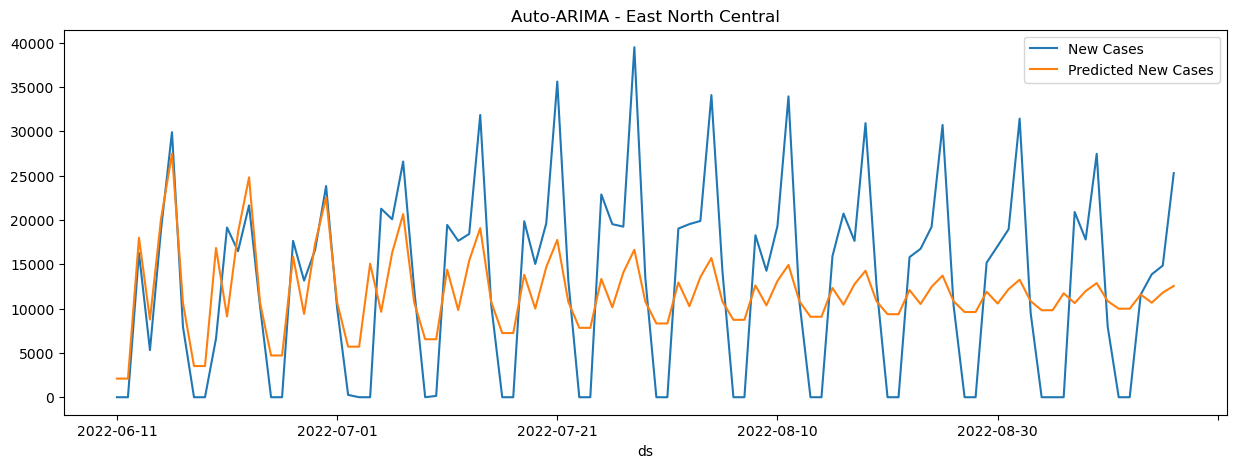

<Figure size 1500x500 with 0 Axes>

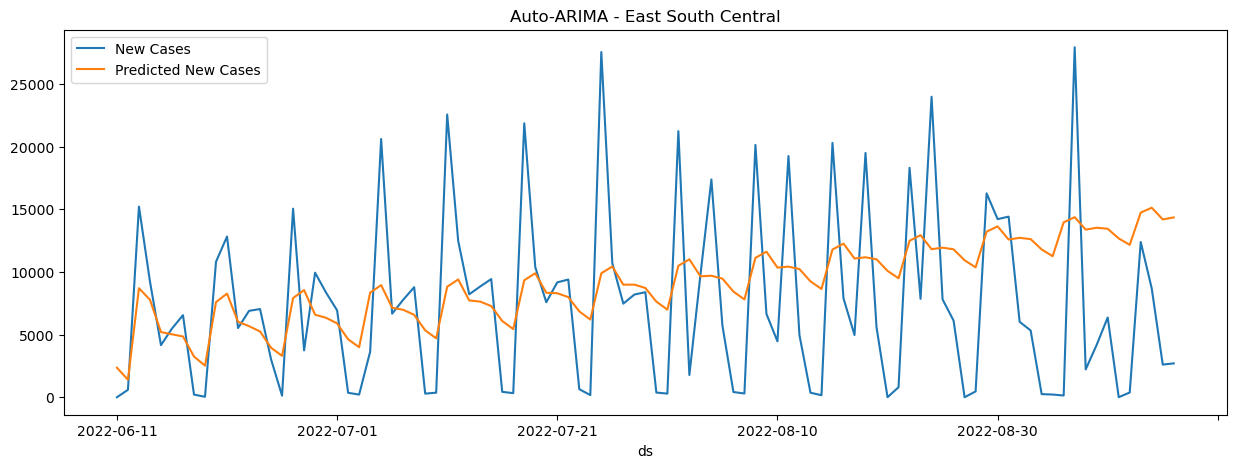

<Figure size 1500x500 with 0 Axes>

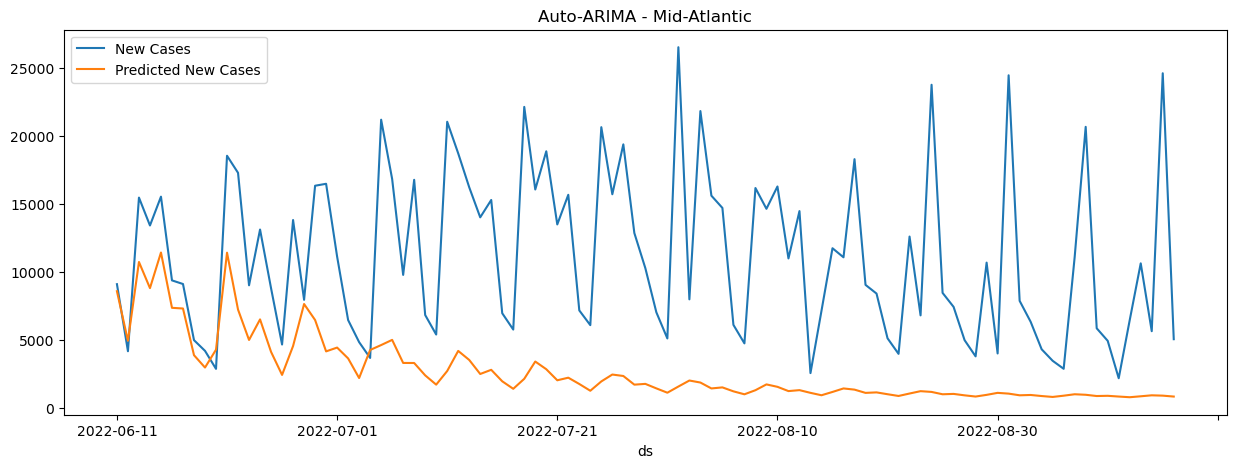

<Figure size 1500x500 with 0 Axes>

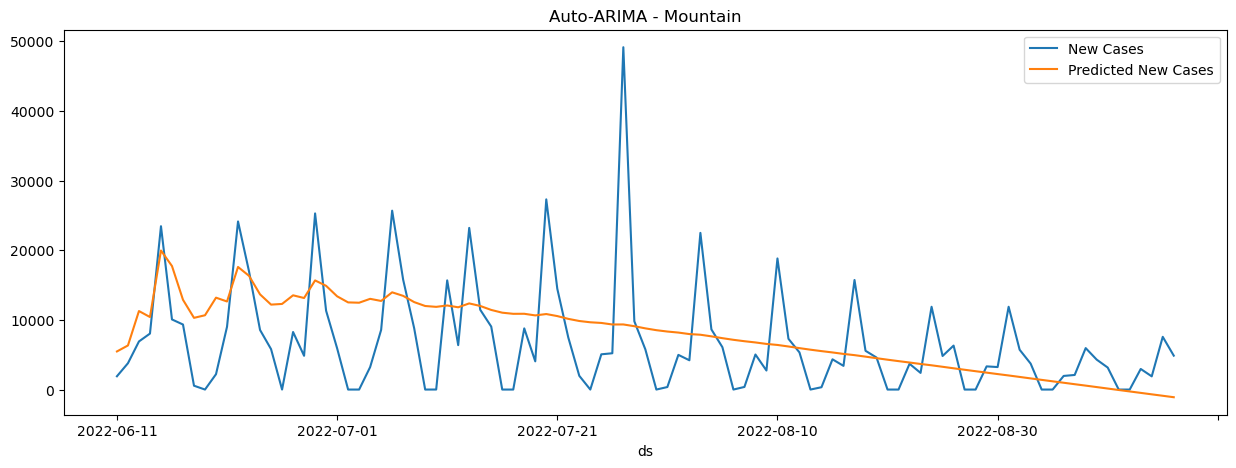

<Figure size 1500x500 with 0 Axes>

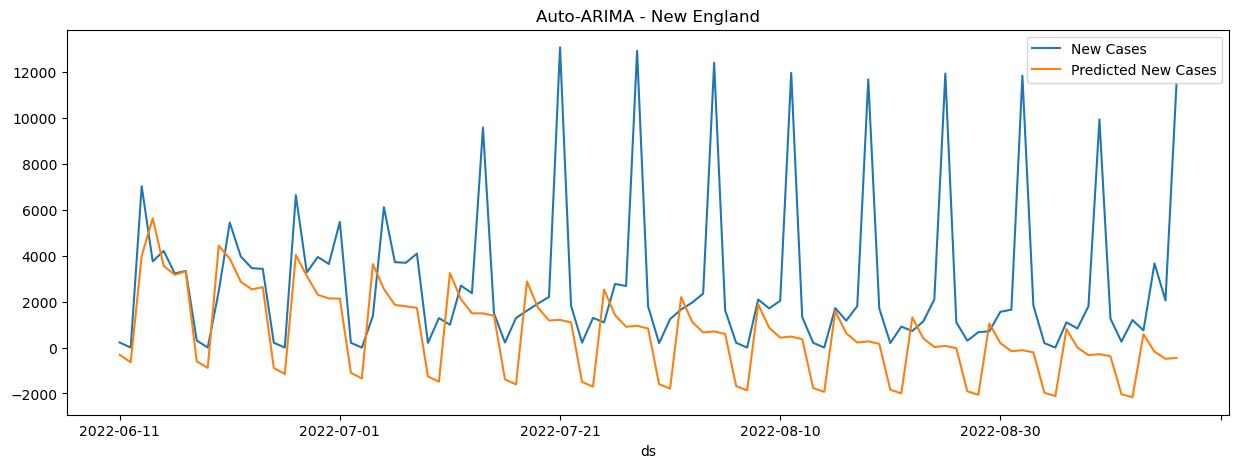

<Figure size 1500x500 with 0 Axes>

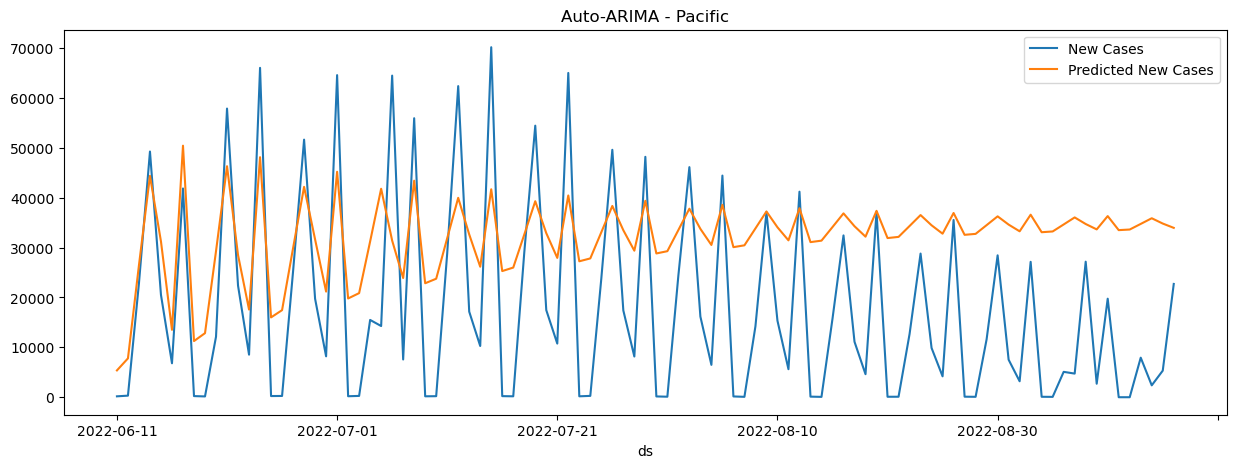

<Figure size 1500x500 with 0 Axes>

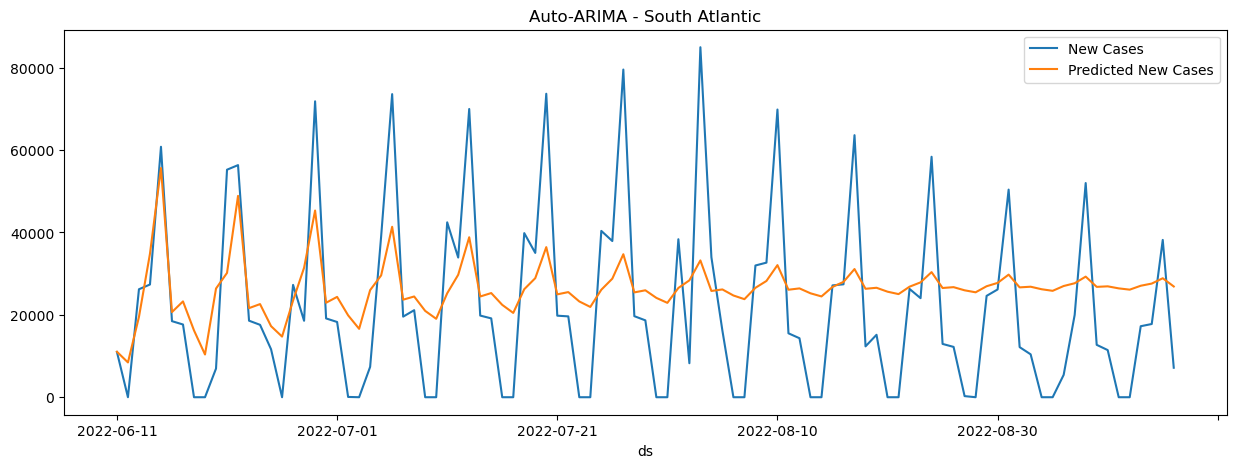

<Figure size 1500x500 with 0 Axes>

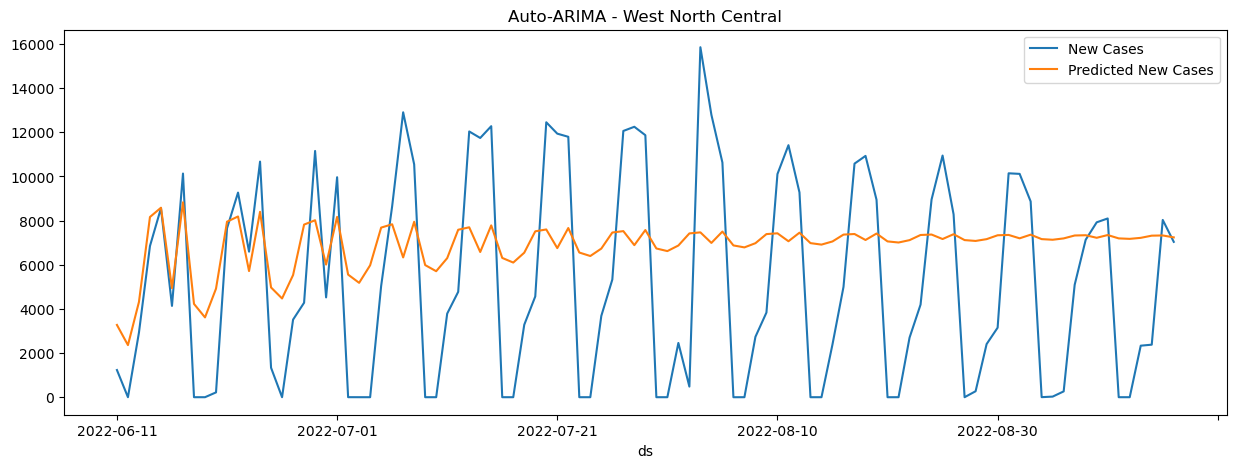

<Figure size 1500x500 with 0 Axes>

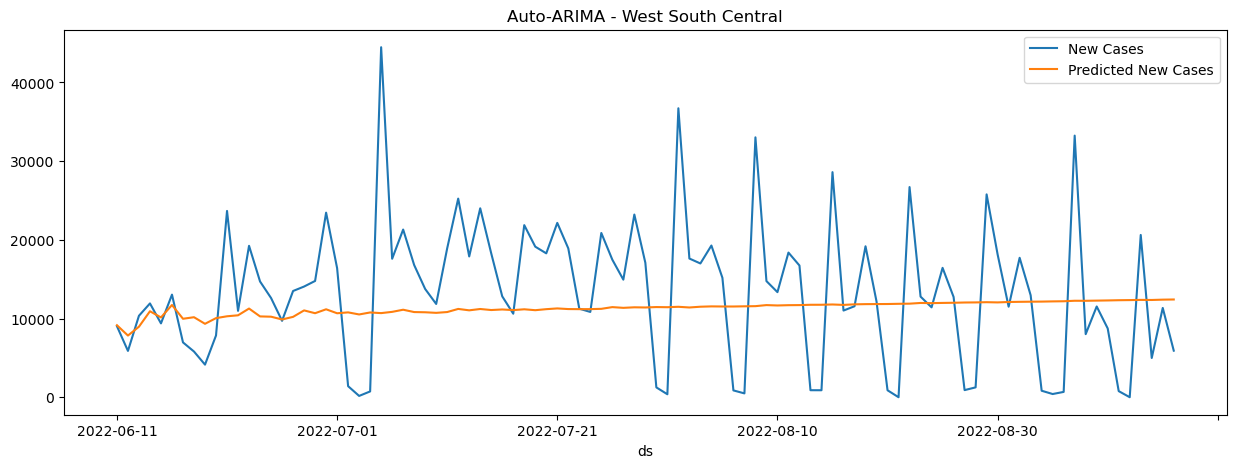

In [29]:
params = []
smapes = []
mases = []
for data1 in [enc, esc, midatl, mount, ne, pac, satl, wnc, wsc]:
# for data1 in [enc]:
    start = time.time()
    print(data1.region.unique()[0])
    data = data1[['date', 'new_confirmed']].rename(columns = {'date': 'ds', 'new_confirmed': 'y'})
    size = round(data.shape[0]*0.1)
    train = data.iloc[:-size]
    test = data.iloc[-size:].reset_index().drop(columns = 'index')
    model = auto_arima(train.y, start_p = 0, max_p = 10, 
                       start_d = 0, max_d = 2, start_q = 0, max_q = 10,
                       start_P=0, start_Q=0,
                       max_P=10, D=0, max_D = 2, max_Q=10, m = 7,
                       seasonal = True, stepwise = True, trace=True,
                       error_action='ignore', suppress_warnings=True,
                       out_of_sample_size = size)
    print(model.aic())
    train_pred=model.fittedvalues()
    test_pred=model.predict(n_periods=len(test))
    # pd.concat([(pd.concat([train, train_pred], axis = 1)).rename(columns = {"ds": 'date', "y": "actual", 0: "forecast"}), 
    #        (pd.concat([test, test_pred.reset_index().drop(columns = 'index')], axis = 1)).rename(columns = {"ds": 'date', "y": "actual", 0: "forecast"})]
    #        ,axis = 0).reset_index().drop(columns = 'index').plot(figsize = (15,5))
    df = pd.concat([test, pd.DataFrame({'forecast': test_pred})], axis = 1)
    plt.figure(figsize = (15,5))
    pd.DataFrame({'New Cases': df.y, 'Predicted New Cases': df.forecast}).set_index(df.ds).plot(figsize = (15,5))
    plt.title('Auto-ARIMA - ' + data1.region.unique()[0])
    print(data1.region.unique()[0])
    print('MASE: ', mean_absolute_scaled_error(df.y, df.forecast, y_train = train.y))
    print('RMSE: ', np.sqrt(mean_squared_error(df.y, df.forecast, squared = False)))
    print('MAE: ', mean_absolute_error(df.y, df.forecast))
    print(time.time() - start)
